In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from gnuradio import digital
import struct
plt.rcParams['figure.figsize'] = (7, 3.5)

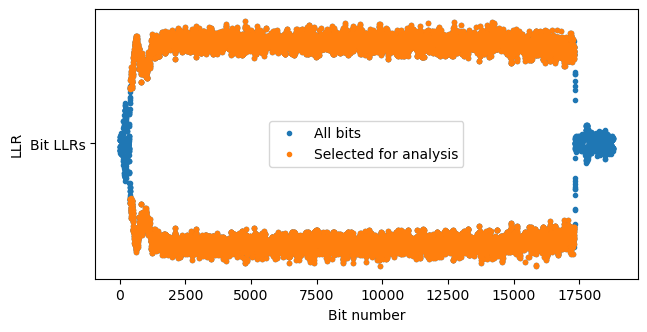

In [2]:
x = np.fromfile('LLRs.f32', 'float32')
bits_sel = range(400, 17300)
plt.plot(x, '.')
plt.plot(np.arange(x.size)[bits_sel], x[bits_sel], '.')
plt.plot('Bit LLRs')
plt.xlabel('Bit number')
plt.ylabel('LLR')
plt.legend(['All bits', 'Selected for analysis'])

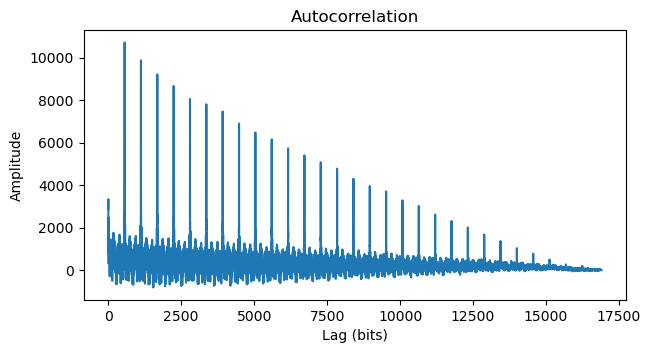

In [3]:
bits = 2*np.fromfile('bits_descrambled.u8', 'uint8').astype('int')[bits_sel]-1
bits = -bits
corr = scipy.signal.correlate(bits, bits)
plt.plot(np.arange(1, corr.size//2+1), corr[corr.size//2+1:])
plt.title('Autocorrelation')
plt.xlabel('Lag (bits)')
plt.ylabel('Amplitude');

In [4]:
L = np.argmax(corr[corr.size//2+1:])+1
L

560

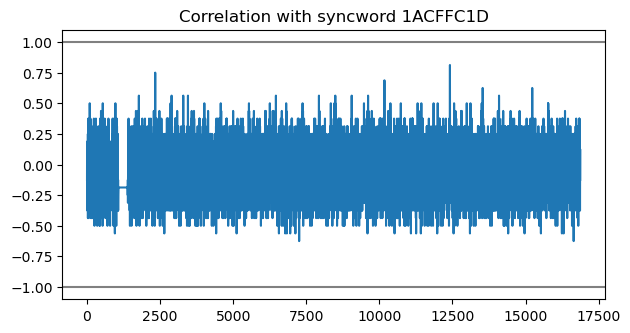

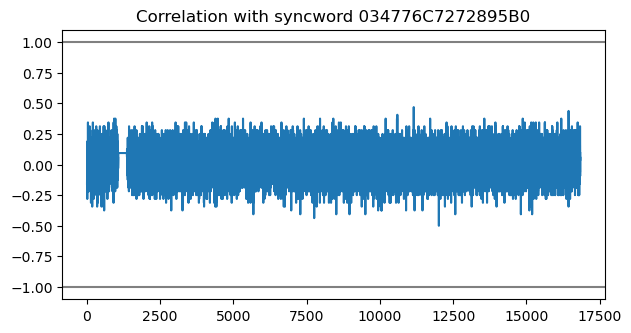

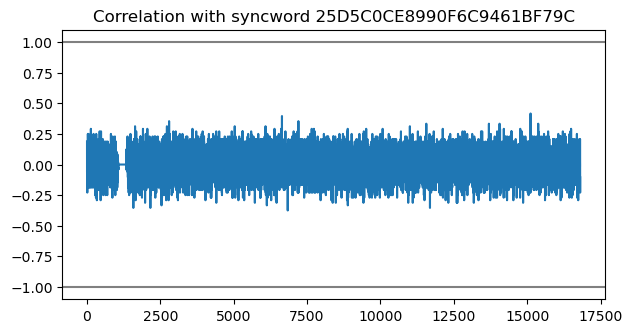

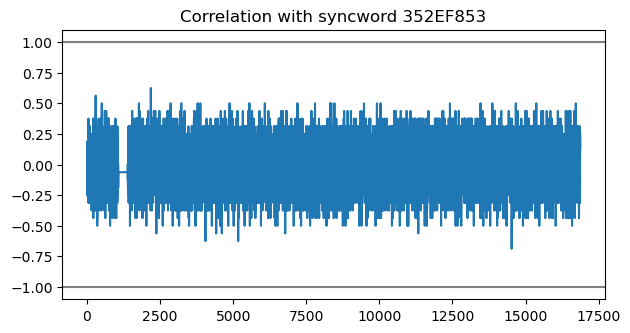

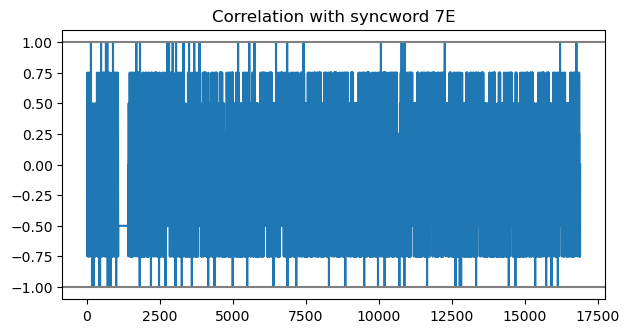

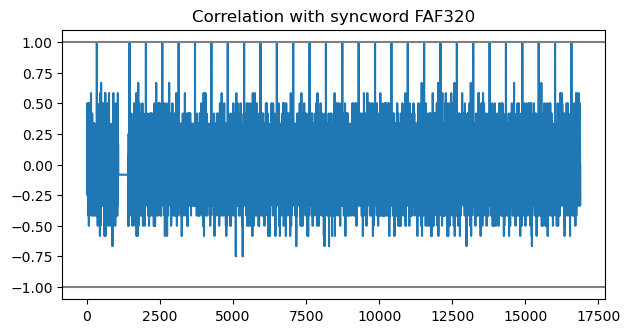

In [5]:
syncwords = ['1ACFFC1D', '034776C7272895B0', '25D5C0CE8990F6C9461BF79C', '352EF853', '7E', 'FAF320']
for syncword_hex in syncwords:
    syncword = 2*np.unpackbits(np.frombuffer(bytes.fromhex(syncword_hex), dtype = 'uint8')).astype('int')-1
    plt.figure()
    plt.title(f'Correlation with syncword {syncword_hex}')
    plt.plot(np.correlate(bits, syncword)/syncword.size)
    plt.axhline(y=-1, color='grey')
    plt.axhline(y=1, color='grey')

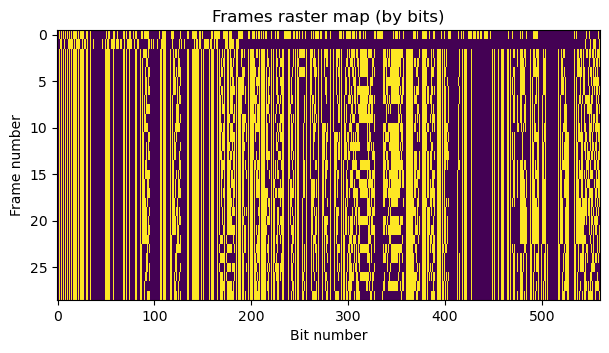

In [6]:
L = 560
skip = 320
y = bits[skip:]
y = y[:y.size//L*L].reshape(-1, L)
plt.imshow(y, aspect='auto', interpolation='none')
plt.title('Frames raster map (by bits)')
plt.xlabel('Bit number')
plt.ylabel('Frame number');

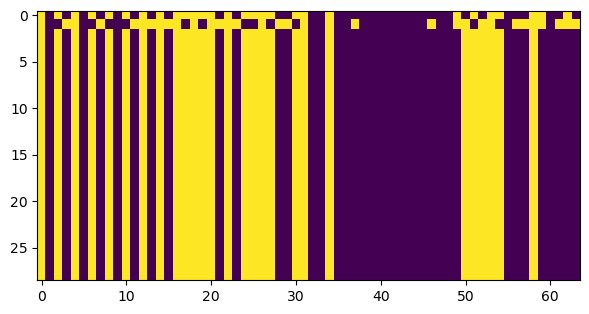

In [7]:
plt.imshow(y[:, :64], aspect='auto', interpolation='none')

In [8]:
bytes(np.packbits(y[-1, :64] >= 0)).hex()

'aaaafaf320003e20'

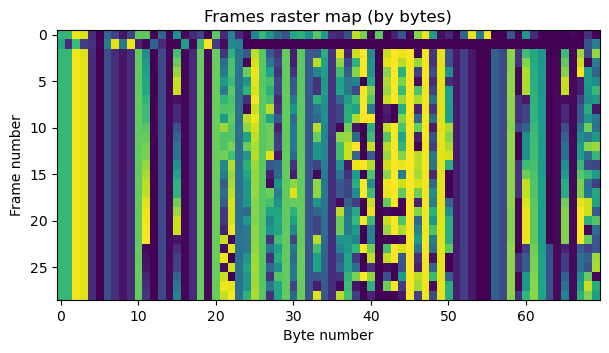

In [9]:
z = np.packbits(y >= 0, axis=1)
plt.imshow(z, aspect='auto', interpolation='none')
plt.title('Frames raster map (by bytes)')
plt.xlabel('Byte number')
plt.ylabel('Frame number');

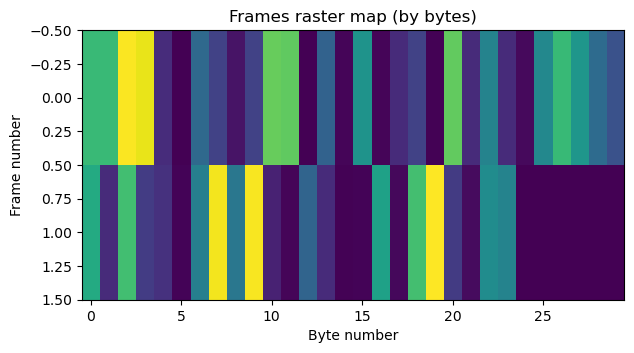

In [10]:
plt.imshow(z[:2, :30], aspect='auto', interpolation='none')
plt.title('Frames raster map (by bytes)')
plt.xlabel('Byte number')
plt.ylabel('Frame number');

In [11]:
crc_calc = digital.crc(16, 0x1021, 0xFFFF, 0x0, False, False)

In [12]:
def check_crc(frame):
    return crc_calc.compute(frame[8:-2]) == struct.unpack('>H', bytes(frame[-2:]))[0]

In [13]:
check_crc(np.concatenate(z[:2]))

False

In [14]:
[check_crc(zz) for zz in z]

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [15]:
bytes(z[0, :8]).hex()

'aaaafaf320005632'

In [16]:
bytes(z[-1, :8]).hex()

'aaaafaf320003e20'